# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy as sp
import scipy.io.wavfile as wf
import librosa
import librosa.display
import IPython.display as ipd
from itertools import cycle
%matplotlib inline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Preparing the CSV

In [2]:
audiopath=[]
csv = pd.read_csv('development.csv')
for index, row in csv.iterrows():
    file_name = row['path']
    audiopath.append(file_name)

In [3]:
csv['intention']= csv['action'] + csv['object']
csv

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,intention
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,change languagenone
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,activatemusic
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,deactivatelights
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,increasevolume
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,increasevolume
...,...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,decreasevolume
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights


In [6]:
#data is not balance
csv['intention'].value_counts()

increasevolume         2614
decreasevolume         2386
increaseheat           1209
decreaseheat           1189
change languagenone    1113
activatemusic           791
deactivatelights        552
Name: intention, dtype: int64

In [7]:
df= csv.copy()

### Extract MFFCs


#### This code get duration of all data then trim audios and pad all data to (10.5 (s)). Finally extract MFFCs from them.

In [8]:
DBT=[]
mfccs= []
for i in range(0, 9854):
    path=(audiopath[i])
    x,sr= librosa.load(path)
    Duration_Before_Trim= librosa.get_duration(filename=path)
    trim=librosa.effects.trim(x,top_db=20)
    o=231525-len(trim[0])
    paddig=np.pad(trim[0],(0,o))
    q= librosa.feature.mfcc(y=paddig, sr=sr)
    DBT.append(Duration_Before_Trim)
    mfccs.append(q)

# Visualizations

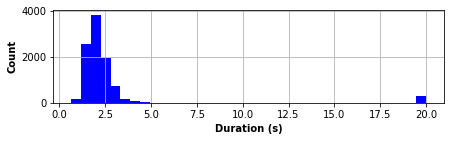

In [9]:
plt.figure(figsize=(7,1.7))
plt.hist(DBT, color = 'blue', bins = int(180/5))
plt.xlabel('Duration (s)', fontweight = 'bold')
plt.ylabel('Count', fontweight = 'bold')
plt.grid()
plt.show()

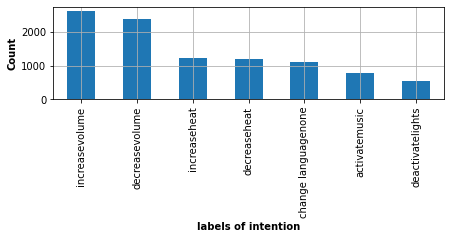

In [10]:
ax=csv['intention'].value_counts().plot(kind='bar', colormap = 'tab10', figsize=(7,1.7))
plt.xlabel("labels of intention",fontweight = 'bold')
plt.ylabel("Count",fontweight = 'bold')
plt.grid()
plt.show()

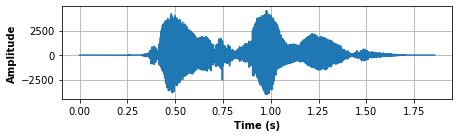

In [11]:
wavfile= audiopath[0]
a, b= wf.read(wavfile)

duration= len(b)/a 
c= np.linspace(0,duration,len(b))
plt.figure(figsize=(7,1.7))
plt.plot(c,b)
plt.grid()
plt.xlabel('Time (s)', fontweight = 'bold')
plt.ylabel('Amplitude', fontweight = 'bold')
plt.show()

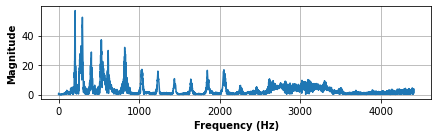

In [12]:
k,sr= librosa.load(audiopath[0])

a = np.fft.fft(k)
a_mag = np.absolute(a)
plt.figure(figsize=(7,1.7))
b = np.linspace(0, sr, len(a_mag))
b_bins = int(len(a_mag)*0.2)  
plt.plot(b[:b_bins], a_mag[:b_bins])
plt.ylabel('Magnitude', fontweight = 'bold')
plt.xlabel('Frequency (Hz)', fontweight = 'bold')
plt.grid()
plt.show()

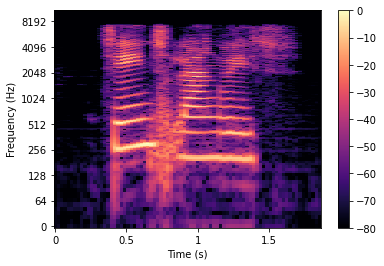

<Figure size 360x288 with 0 Axes>

In [13]:
k, sr= librosa.load(audiopath[0])
a= librosa.stft(k)
b= librosa.amplitude_to_db(np.abs(a), ref=np.max)

fig, ax= plt.subplots()
pic= librosa.display.specshow(b, x_axis='time', y_axis='log', ax=ax)
ax.set(ylabel='Frequency (Hz)', xlabel='Time (s)')
fig.colorbar(pic, ax=ax)
plt.figure(figsize=(5,4))
plt.show()

# Train Data

In [14]:
feature= np.array(mfccs)
feature= feature.reshape(feature.shape[0], -1)

In [34]:
x= feature
y= df['intention']

In [30]:
#split dataset to 80%(train)/20%(test)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

### SMOTE Oversampling

In [35]:
smote = SMOTE(random_state=4, sampling_strategy='not majority')

X_train, Y_train = smote.fit_resample(x,y)

In [21]:
#data after oversampling, now it's balance
Y_train.value_counts()

change languagenone    2614
activatemusic          2614
deactivatelights       2614
increasevolume         2614
decreasevolume         2614
increaseheat           2614
decreaseheat           2614
Name: intention, dtype: int64

# Classification Models

In [ ]:
#tunning random forest with grid search

#x = X_train
#y = Y_train
#RF= RandomForestClassifier()
#param= {'criterion':['gini', 'entropy'], 'max_depth':[None,5,10], 'n_estimators':[50,100,200,2000]}
#GS= GridSearchCV(RF, param)
#%time GS.fit(x,y)
#GS.best_score_
#GS.best_params_

In [22]:
#final Random Forest Model

#x_train = X_train
#y_train = Y_train
#RF = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_depth=None, random_state=4)
#RF.fit(x_train, y_train)
#preds_train = RF.predict(x_train)
#preds_test = RF.predict(x_test)
#print('Accuracy', round(accuracy_score(y_test, preds_test), 5), '\n')

RandomForestClassifier(criterion='entropy', n_estimators=2000, random_state=4)

In [ ]:
#tunning lightGBM with grid search

#x = X_train
#y = Y_train
#LGBM= lightgbm.LGBMClassifier()
#param= {'num_leaves':[25,50,70], 'learning_rate':[0.01,0.05,0.1], 'n_estimators':[100,1000,2000]}
#GS= GridSearchCV(LGBM, param)
#%time GS.fit(x,y)
#GS.best_score_
#GS.best_params_

In [36]:
#final LGBM Model

x_train = X_train
y_train = Y_train
LGBM= lightgbm.LGBMClassifier(random_state=4, n_estimators=2000, num_leaves=70, learning_rate=0.05)
LGBM.fit(x_train, y_train)
#preds_train = LGBM.predict(x_train)
#preds_test = LGBM.predict(x_test)
#print('Accuracy', round(accuracy_score(y_test, preds_test), 5), '\n')

LGBMClassifier(learning_rate=0.05, n_estimators=2000, num_leaves=70,
               random_state=4)

# Test Data

In [37]:
audiotestpath=[]
csv_test = pd.read_csv('evaluation.csv')
for index, row in csv_test.iterrows():
    file_name = row['path']
    audiotestpath.append(file_name)

In [38]:
mfccs_test= []
for i in range(0, 1455):
    x_test,sr= librosa.load(audiotestpath[i])
    trim_test=librosa.effects.trim(x_test,top_db=20)
    o_test=231525-len(trim_test[0])
    paddig_test=np.pad(trim_test[0],(0,o_test))
    q_test= librosa.feature.mfcc(y=paddig_test, sr=sr)
    mfccs_test.append(q_test)

In [39]:
feature_test= np.array(mfccs_test)
feature_test= feature_test.reshape(feature_test.shape[0], -1)

In [40]:
x_test= feature_test
y_predict = LGBM.predict(x_test)

In [41]:
csv_test['Predicted'] = y_predict
final_df= csv_test[['Id', 'Predicted']]

In [43]:
final_df.to_csv("C:/Users/ASUS/Final_csv.csv", sep=',', index=False)